In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel

# Preparation of the transport network.
## Replaces scheduled bus network with on-demand services.
## Needs clustered PT network and connectors.

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Loading StepModel with PT network...
try:
    sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
except FileNotFoundError:
    sm = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_pt_network_agg')
try:
    ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
except FileNotFoundError:
    ae = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_pt_access_egress')
sm.links = gpd.GeoDataFrame(sm.links)
sm.nodes = gpd.GeoDataFrame(sm.nodes)
sm.zones = gpd.GeoDataFrame(sm.zones)
sm.centroids = gpd.GeoDataFrame(ae.centroids)
sm.footpaths = gpd.GeoDataFrame(ae.footpaths)
sm.zone_to_transit = gpd.GeoDataFrame(ae.zone_to_transit)

In [6]:
len(sm.nodes)

36462

In [7]:
len(sm.links)

403656

In [8]:
# Drop scheduled bus services outside of cities
drop_nodes = sm.nodes.loc[(sm.nodes['route_type']=='bus')
                          & (sm.nodes['FID'].map(sm.zones['urbanisation'])!=1)
                         ].index
# Keep nodes from trips to/from cities
city_trips = set(sm.links.loc[~sm.links['a'].isin(drop_nodes), 'trip_id']).union(
             set(sm.links.loc[~sm.links['b'].isin(drop_nodes), 'trip_id']))
drop_nodes = set(drop_nodes) \
             - set(sm.links.loc[sm.links['trip_id'].isin(city_trips), 'a']) \
             - set(sm.links.loc[sm.links['trip_id'].isin(city_trips), 'b'])
# Drop
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(drop_nodes))
                                  | (sm.footpaths['b'].isin(drop_nodes)))]
sm.zone_to_transit = sm.zone_to_transit.loc[~((sm.zone_to_transit['a'].isin(drop_nodes))
                                              | (sm.zone_to_transit['b'].isin(drop_nodes)))]
sm.links = sm.links.loc[~((sm.links['a'].isin(drop_nodes))
                          | (sm.links['b'].isin(drop_nodes)))]
sm.nodes = sm.nodes.drop(list(drop_nodes))

In [9]:
# Drop broken trip sequences
def test_sequences_save(trip):
    if len(trip)!=trip['link_sequence'].max():
        return list(trip.index)
broken = sm.links.loc[(sm.links['route_type']=='bus')
                     ].groupby('trip_id').apply(test_sequences_save)
if len(broken) > 1:
    print('Dropped {} links with broken sequences'.format(len(broken.loc[broken.notna()].sum())))
    sm.links.drop(broken.loc[broken.notna()].sum(), inplace=True)

Dropped 15324 links with broken sequences


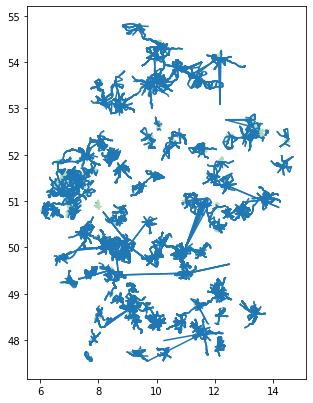

In [10]:
# Plot the coverage of scheduled bus lines
if manual:
    sm.links.loc[sm.links['route_type']=='bus', 'geometry'].plot(
        ax=sm.zones.loc[sm.zones['urbanisation']==1].plot(color='green', alpha=.3, figsize=(5,8)))

In [11]:
len(sm.nodes)

20084

In [12]:
len(sm.links)

211164

## Build on-demand services

One service to every other PT node and centroid within a distance threshold from each zone's centroid.

In [17]:
def links_nodes_footpaths_connectors_from_ntlegs(ntlegs, prefix):
    ntlegs = gpd.GeoDataFrame(ntlegs, crs=sm.epsg)
    ntlegs['a'] = ntlegs['a'].astype(str)
    ntlegs['b'] = ntlegs['b'].astype(str)
    
    # Build links
    links = ntlegs[['time', 'geometry']]
    if 'length' in sm.links.columns:
        links['length'] = ntlegs['distance']
    links['route_type'] = 'bus'
    links['route_type_disagg'] = 'on-demand'
    links['headway'] = 0
    links['link_sequence'] = 1
    links['trip_id'] = ntlegs['a'] + '-' + ntlegs['b']
    links['route_id'] = ntlegs['a']
    links['a'] = prefix + ntlegs['a']
    links['b'] = prefix + ntlegs['b']
    links.index = [prefix+str(i) for i in range(len(links))]
    links.drop_duplicates(['a', 'b'], inplace=True)
    
    # Build nodes
    nodes = ntlegs[['a']]
    nodes['geometry'] = pd.concat([
        ntlegs.loc[ntlegs['direction']=='access', 'geometry'
                  ].apply(lambda l: geometry.Point(l.coords[0])),
        ntlegs.loc[ntlegs['direction']!='access', 'geometry'
                  ].apply(lambda l: geometry.Point(l.coords[1]))])
    nodes['FID'] = ntlegs['a'].replace(sm.nodes['FID'])
    nodes['route_type'] = 'bus'
    nodes.index = prefix + ntlegs['a']
    nodes.drop_duplicates('a', keep='first', inplace=True)
    nodes.drop('a', axis=1, inplace=True)
    
    # Build footpaths
    foot = gpd.GeoDataFrame()
    # Build footpaths if there are PT nodes to connect to
    if len(set(ntlegs['a']).intersection(set(sm.nodes.index))) > 0:
        # from on-demand node to PT
        mask = (ntlegs['direction']=='access') & (ntlegs['b'].isin(sm.nodes.index))
        foot_a = ntlegs.loc[mask, ['b', 'direction']]
        foot_a['a'] = prefix + ntlegs.loc[mask, 'b']
        foot_a['geometry'] = ntlegs.loc[mask, 'geometry'].apply(
            lambda l: geometry.LineString([l.coords[1], l.coords[1]]))
        foot_a.index = 'foot_a_' + foot_a['a']
        # from PT to on-demand node
        mask = (ntlegs['direction']=='eggress') & (ntlegs['a'].isin(sm.nodes.index))
        foot_b = ntlegs.loc[mask, ['a', 'direction']]
        foot_b['b'] = prefix + ntlegs.loc[mask, 'a']
        foot_b['geometry'] = ntlegs.loc[mask, 'geometry'].apply(
            lambda l: geometry.LineString([l.coords[0], l.coords[0]]))
        foot_b.index = 'foot_b_' + foot_b['b']
        # Put it together
        foot = pd.concat([foot_a, foot_b])
        foot['distance'] = 0
        foot['time'] = params['on-demand_bus']['interchange_time_pt']
        foot['speed'] = params['pt_access']['speed_walk']
        foot.drop_duplicates(['a', 'b'], inplace=True)
    
    # Build centroid connectors (zone_to_transit)
    # to the starting node
    mask = (ntlegs['direction']=='access')
    conn_a = ntlegs.loc[mask, ['a', 'direction']]
    conn_a['b'] = prefix + ntlegs.loc[mask, 'a']
    conn_a['geometry'] = ntlegs.loc[mask, 'geometry'].apply(
        lambda l: geometry.LineString([l.coords[0], l.coords[0]]))
    conn_a['u'] = conn_a['a'].map(sm.zones['urbanisation'])
    # from the starting node
    conn_b = conn_a.rename(columns={'a': 'b', 'b': 'a'})
    conn_b['direction'] = 'eggress' # name in quetzal
    # Merge
    conn = pd.concat([conn_a, conn_b])
    mask = (ntlegs['direction']=='access') & (ntlegs['b'].isin(sm.zones.index))
    if len(ntlegs.loc[mask]) > 0:
        # to the ending node
        conn_a = ntlegs.loc[mask, ['b', 'direction']].rename(columns={'b': 'a'})
        conn_a['b'] = prefix + ntlegs.loc[mask, 'b']
        conn_a['geometry'] = ntlegs.loc[mask, 'geometry'].apply(
            lambda l: geometry.LineString([l.coords[1], l.coords[1]]))
        conn_a['u'] = conn_a['a'].map(sm.zones['urbanisation'])
        # from the ending node
        conn_b = conn_a.rename(columns={'a': 'b', 'b': 'a'})
        conn_b['direction'] = 'eggress' # name in quetzal
        # Merge
        conn = pd.concat([conn_a, conn_b, conn])
    conn['route_type'] = 'bus'
    conn['distance'] = 0
    conn['speed'] = params['pt_access']['speed_walk']
    conn['time'] = 0
    conn.drop_duplicates(['a', 'b'], inplace=True)
    conn.reset_index(inplace=True, drop=True)
    
    return links, nodes, foot, conn

In [18]:
# Define the zones that should get on-demand services
excluded = ['DEF07_3', 'outer_2', 'DE94A_2', 'DE94H_3', 'DE94H_4',
            'DE947_4', 'DE947_2', 'DE94C_7', 'DEF07_99']
mask = (sm.zones['urbanisation']!=1) & ~(sm.zones['FID'].isin(excluded))

In [19]:
# Build services to PT nodes
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids.loc[mask],
    sm.nodes.loc[sm.nodes['route_type']!='bus'],
    n_neighbors=50, # double that times number of zones will be added to links
    coordinates_unit=sm.coordinates_unit)
ntlegs = ntlegs.loc[ntlegs['distance']<=params['on-demand_bus']['max_dist_pt']]
ntlegs = ntlegs.loc[ntlegs['distance']>params['access-egress_links']['walk_max_dist']]
ntlegs['time'] = ntlegs['distance']/1000 / params['on-demand_bus']['speed'] * 3600
l,n,f,c = links_nodes_footpaths_connectors_from_ntlegs(ntlegs, 'od_')
sm.links = pd.concat([sm.links, l])
sm.nodes = pd.concat([sm.nodes, n])
sm.footpaths = pd.concat([sm.footpaths, f])
sm.zone_to_transit = pd.concat([sm.zone_to_transit, c]).reset_index(drop=True)

In [20]:
# Build services from zone to zone
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids.loc[mask],
    sm.centroids,
    n_neighbors=15,
    coordinates_unit=sm.coordinates_unit)
ntlegs = ntlegs.loc[ntlegs['distance']<=params['on-demand_bus']['max_dist_centroids']]
ntlegs = ntlegs.loc[ntlegs['a']!=ntlegs['b']]
ntlegs['time'] = ntlegs['distance']/1000 / params['on-demand_bus']['speed'] * 3600
l,n,f,c = links_nodes_footpaths_connectors_from_ntlegs(ntlegs, 'odd_')
sm.links = pd.concat([sm.links, l])
sm.nodes = pd.concat([sm.nodes, n])
sm.footpaths = pd.concat([sm.footpaths, f])
sm.zone_to_transit = pd.concat([sm.zone_to_transit, c]).reset_index(drop=True)

In [21]:
len(sm.links)

281462

In [22]:
len(sm.nodes)

31282

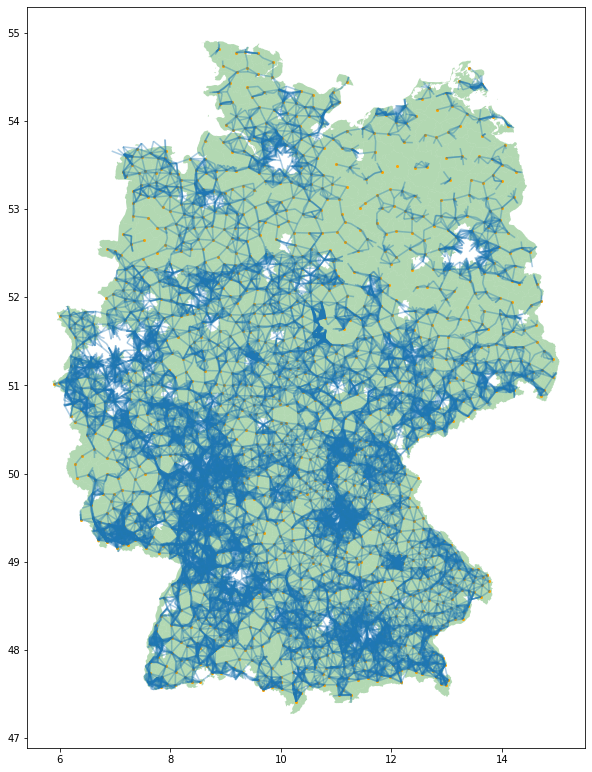

In [23]:
# On-demand service coverage
if manual:
    sm.links.loc[sm.links.index.str.startswith('od'), 'geometry'].plot(
        alpha=.2,
        ax=sm.centroids.loc[mask].plot(color='orange', markersize=4,
            ax=sm.zones.loc[mask].plot(color='green', alpha=.3, figsize=(10,16))))

## Test network integrity

In [24]:
# Every zone should have an access and an egress link to PT
# If not, they might be islands? Check manually
print(sm.zones.loc[~sm.zones['FID'].isin(list(sm.zone_to_transit['a']))].index)
print(sm.zones.loc[~sm.zones['FID'].isin(list(sm.zone_to_transit['b']))].index)

Index(['DEF07_3'], dtype='object', name='index')
Index(['DEF07_3'], dtype='object', name='index')


In [25]:
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    assert len(sm.missing_nodes) == 0
    print('Number of orphan nodes: {}'.format(len(sm.orphan_nodes)))
    if len(sm.orphan_nodes) > 0:
        sm.nodes = sm.nodes.drop(sm.orphan_nodes)
        sm.nodes.shape

no road_links or road_nodes


## Save model
And reduce the file size

In [ ]:
assert scenario != 'base', 'The base scenario cannot have an on-demand service bus network as it does not yet exist'

In [65]:
# Cast columns to int
cols = ['time', 'link_sequence', 'headway']
sm.links[cols] = sm.links[cols].astype(int)

In [66]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['a', 'b', 'link_sequence', 'route_id', 'time', 'trip_id', 'headway', 'route_type_disagg']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [26]:
# Saving model...
sm.to_json(model_path + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [01:34<00:00,  2.63s/it]


In [68]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')

In [69]:
# Save reduced access/egress links
sm.to_json(model_path + 'de_pt_access_egress', only_attributes=[
    'centroids', 'footpaths', 'zone_to_transit'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.31it/s]
